In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageOps
from scipy.ndimage import gaussian_filter
from torchvision import models, transforms

### Setup model, transforms, and example image

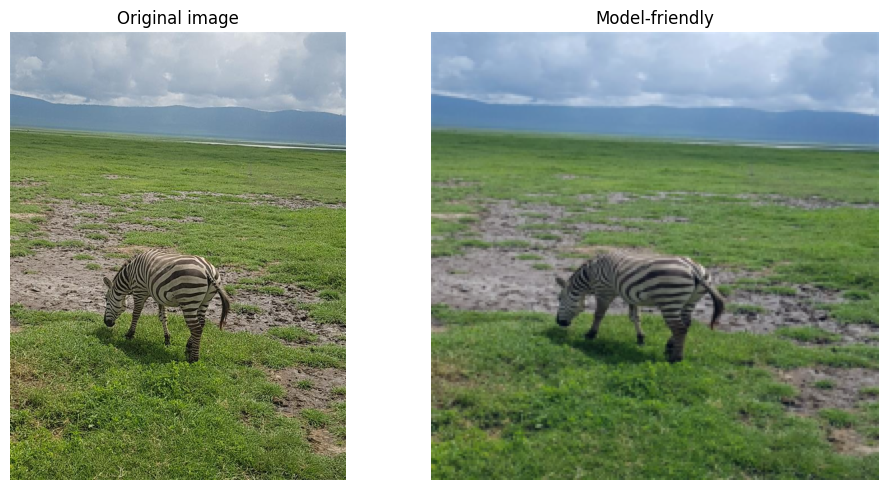

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()

# Load your image here
image_path = "../data/zebra_jacob.jpg"
image = Image.open(image_path)
image = ImageOps.exif_transpose(image) # Potentially flip image if it was taken in portrait mode

transform_human = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# For model input: resize, divides by 255, then normalize with ImageNet statistics
transform_model = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_human = transform_human(image)
image_model = transform_model(image)

# Min-max normalize to [0,1]. Do not give this to the model! Just for plotting
image_model_normalized = (image_model - image_model.min()) / (image_model.max() - image_model.min())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].set_title("Original image")
axs[1].imshow(image_model_normalized.permute(1, 2, 0))
axs[1].axis("off")
axs[1].set_title("Model-friendly")
plt.tight_layout()
plt.show()

### Attribution with raw gradients

In [3]:
input_image = image_model.unsqueeze(0).to(device)
input_image.requires_grad = True

# Forward pass
output = model(input_image) # logits
pred_class = output.argmax(dim=1) # predicted class
score = output[0, pred_class] # largest logit

# Just for fun: whats the probability of the predicted class?
# Class indices https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
print(f"Probability of predicted class: {F.softmax(output, dim=1)[0, pred_class].item():.2%}")
print(f"Predicted class index: {pred_class.item()}") # 340 is zebra. Good job little AI

# Backward pass
model.zero_grad()
score.backward()

# Get gradient wrt. the input image
gradient = input_image.grad.squeeze()
print(f"Image shape: {input_image.shape}")
print(f"Gradient shape: {gradient.shape}")

Probability of predicted class: 99.97%
Predicted class index: 340
Image shape: torch.Size([1, 3, 224, 224])
Gradient shape: torch.Size([3, 224, 224])


### Color importance is rarely intuitive

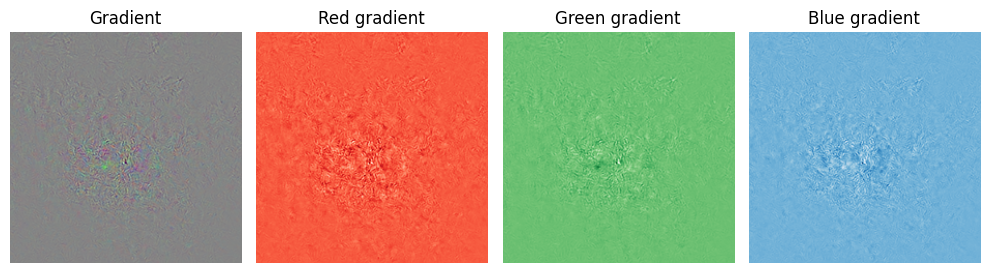

In [4]:
# Plot the gradient with RGB, and each channel in a different color
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
gradient = gradient.cpu().permute(1, 2, 0)
gradient = (gradient - gradient.min()) / (gradient.max() - gradient.min())
axs[0].imshow(gradient)
axs[0].axis("off")
axs[0].set_title("Gradient")

Colors = {"Red": "Reds", "Green": "Greens", "Blue": "Blues"}
for i, channel in enumerate(("Red", "Green", "Blue")):
    axs[i+1].imshow(gradient[:,:,i].cpu().detach().numpy(), cmap=Colors[channel])
    axs[i+1].axis("off")
    axs[i+1].set_title(f"{channel} gradient")
plt.tight_layout()
plt.show()

### Aggregate channels into a single value and clamp

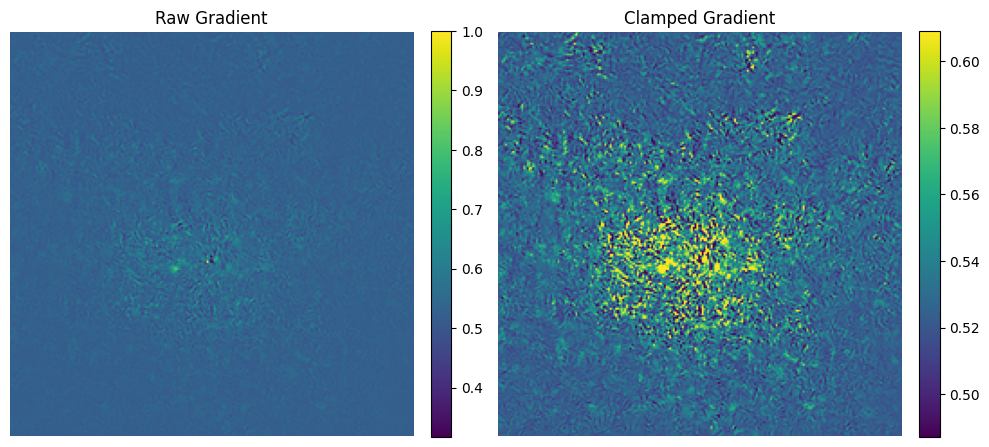

In [5]:
def aggregate_channels(channel_attributions, clamp=True):
    # Multiple options:
    aggregated = channel_attributions.abs().max(dim=-1).values
    #aggregated = channel_attributions.abs().sum(dim=-1)
    #aggregated = channel_attributions.sum(dim=-1).abs()

    # Improves visual nuances
    if clamp:
        return torch.clamp(aggregated, torch.quantile(aggregated.flatten(), 0.01), torch.quantile(aggregated.flatten(), 0.99))   
    return aggregated

gradient_aggregated = aggregate_channels(gradient, clamp=False)
gradient_aggregated_clamped = aggregate_channels(gradient, clamp=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(gradient_aggregated)
axs[0].axis("off")
axs[0].set_title("Raw Gradient")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(gradient_aggregated_clamped)
axs[1].axis("off")
axs[1].set_title("Clamped Gradient")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Gaussian smoothing and overlay

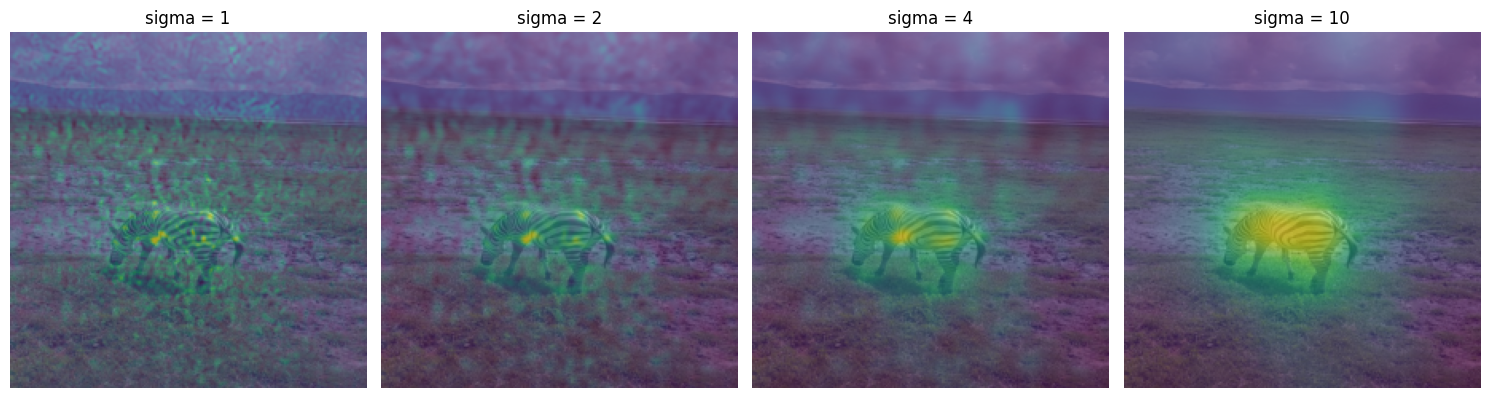

In [6]:
sigmas = (1, 2, 4, 10)
fig, axs = plt.subplots(1, len(sigmas), figsize=(15, 5))
for i, sigma in enumerate(sigmas):
    # Apply gaussian smoothing
    gradient_smoothed = gaussian_filter(gradient_aggregated_clamped, sigma=sigma)

    axs[i].imshow(image_human.permute(1, 2, 0))
    axs[i].imshow(gradient_smoothed, alpha=0.6)
    axs[i].set_title(f"sigma = {sigma}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

### Gradients x Input

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([224, 224, 3])
torch.Size([224, 224])


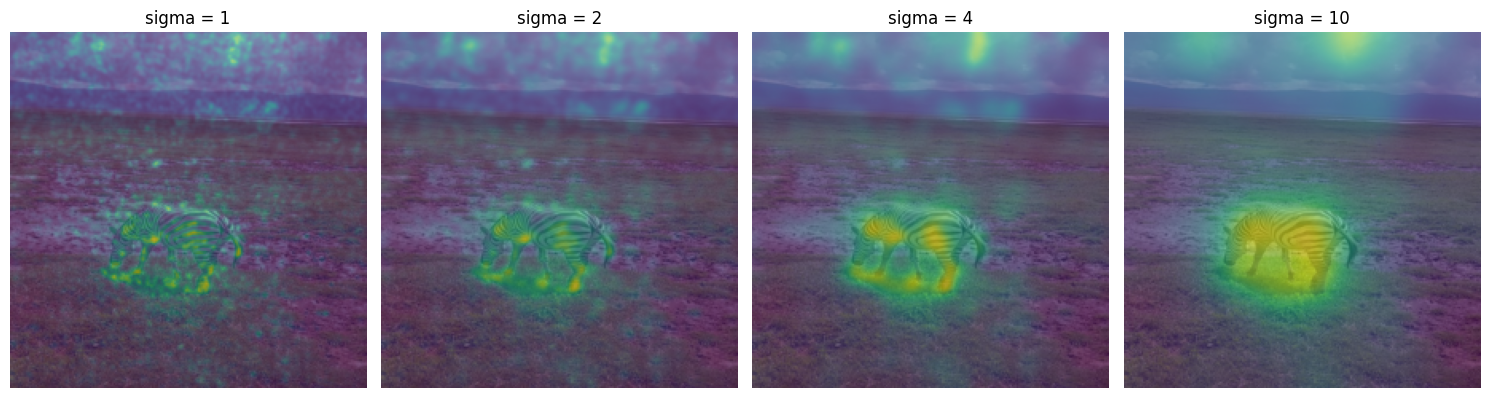

In [7]:
# Recompute the gradient
model.zero_grad(set_to_none=True)
logits = model(input_image)
score = logits[0, pred_class]
score.backward()
gradient = input_image.grad

print(gradient.shape, input_image.shape)
gradient_times_input = gradient * input_image
gradient_times_input = gradient_times_input.squeeze(0).permute(1, 2, 0).detach().cpu()
print(gradient_times_input.shape)
gradient_times_input = aggregate_channels(gradient_times_input)
print(gradient_times_input.shape)

sigmas = (1, 2, 4, 10)
fig, axs = plt.subplots(1, len(sigmas), figsize=(15, 5))
for i, sigma in enumerate(sigmas):
    # Apply gaussian smoothing
    gradient_smoothed = gaussian_filter(gradient_times_input, sigma=sigma)
    gradient_smoothed = (gradient_smoothed / gradient_smoothed.max())

    axs[i].imshow(image_human.permute(1, 2, 0))
    axs[i].imshow(gradient_smoothed, alpha=0.6)
    axs[i].set_title(f"sigma = {sigma}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

### The sky looks important? Or maybe an artifact of the image having large values in this region?

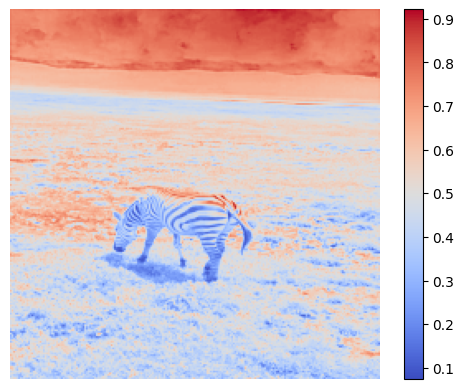

In [8]:
# Plot the absolute max value of the original image
plt.imshow(image_human.permute(1, 2, 0).abs().max(dim=-1).values, cmap="coolwarm")
plt.axis("off")
plt.colorbar()
plt.show()

### Class Activation Maps (CAM)

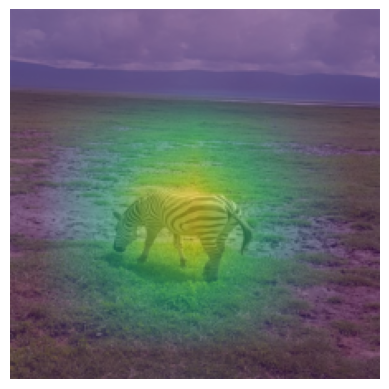

In [9]:
activations = []
def forward_hook(module, inp, out):
    activations.append(out.detach())

# Make sure this is the last conv layer!
handle = model.layer4[1].conv2.register_forward_hook(forward_hook)
with torch.no_grad():
    _ = model(input_image)
handle.remove()
acts = activations[0] # [1, C, H, W]

weights = model.fc.weight[pred_class].view(1, -1, 1, 1)  # [1, C, 1, 1]
cam = torch.sum(torch.relu(weights * acts), dim=1, keepdim=False).squeeze(0) # [H, W]

# Interpolate to original image size
target_size = input_image.shape[-2:]
cam = torch.nn.functional.interpolate(
    cam.unsqueeze(0).unsqueeze(0),
    size=target_size,
    mode="bilinear",
    align_corners=False,
)[0, 0]

plt.imshow(image_human.permute(1, 2, 0))
plt.imshow(cam.cpu().detach().numpy(), alpha=0.5)
plt.axis("off")
plt.show()

### Grad-CAM

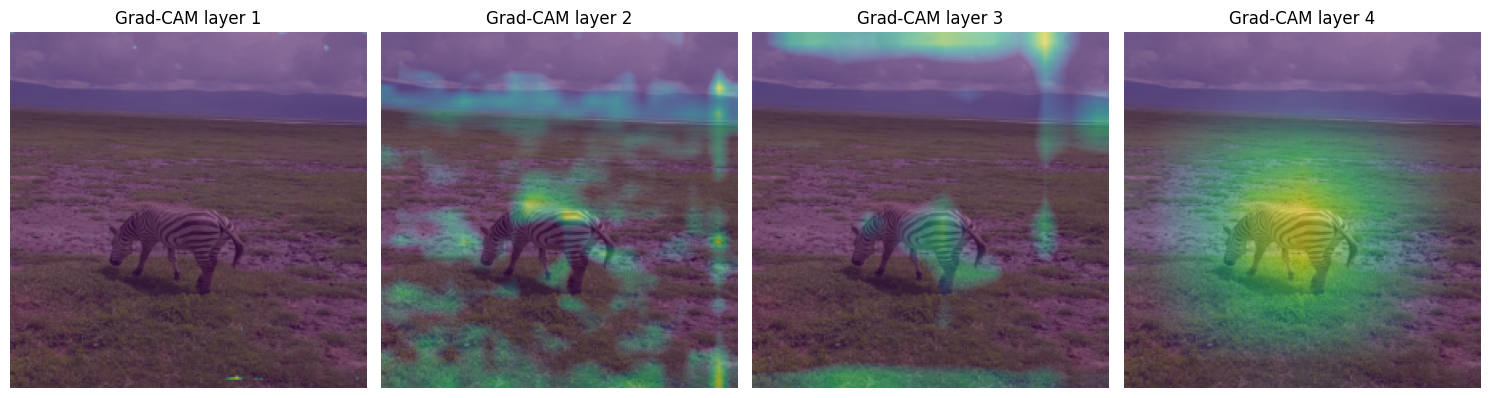

In [10]:
layers = [
    model.layer1[1].conv2,
    model.layer2[1].conv2,
    model.layer3[1].conv2,
    model.layer4[1].conv2,
]

# Storage
layer_activations = {}
layer_gradients = {}
# We save both activations and gradients for each conv layer
def forward_hook(module, inp, out):
    layer_activations[module] = out.detach()

    def backward_hook(grad):
        layer_gradients[module] = grad.detach()

    out.register_hook(backward_hook)

# Register hooks
handles = [layer.register_forward_hook(forward_hook) for layer in layers]

# Forward + backward
model.zero_grad(set_to_none=True)
output = model(input_image)
score = output[0, pred_class]
score.backward()

# Remove forward hooks. Backward hooks are automatically removed
for h in handles:
    h.remove()

# Compute and visualize Grad-CAM for each layer
fig, axs = plt.subplots(1, len(layers), figsize=(15, 15))
for i, layer in enumerate(layers):
    acts = layer_activations[layer] # [1, C, H, W]
    grads = layer_gradients[layer] # [1, C, H, W]
    weights = grads.mean(dim=(2, 3), keepdim=True) # [1, C, 1, 1]

    # Weighted sum of activations
    grad_cam = (weights * acts).sum(dim=1) # [1, H, W]

    # Interpolate to original image size
    grad_cam = torch.nn.functional.interpolate(
        grad_cam.unsqueeze(0),
        size=input_image.shape[-2:],
        mode="bilinear",
        align_corners=False,
    )[0, 0]

    grad_cam = grad_cam.relu().cpu().detach().numpy()

    axs[i].imshow(image_human.permute(1, 2, 0))
    axs[i].imshow(grad_cam, alpha=0.5)
    axs[i].set_title(f"Grad-CAM layer {i+1}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

### Integrated Gradients

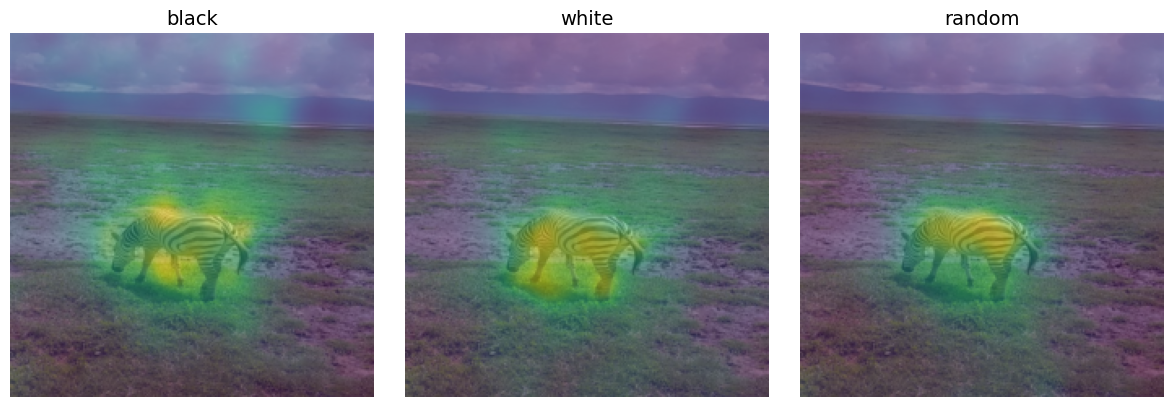

In [11]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Baselines
baselines = {
    "black":  torch.zeros(1, 3, input_image.shape[-2], input_image.shape[-1], device=device),
    "white":  torch.ones(1, 3, input_image.shape[-2], input_image.shape[-1], device=device),
    "random": torch.rand(1, 3, input_image.shape[-2], input_image.shape[-1], device=device),
}

# Normalize baselines to match input_image
for bname, b in baselines.items():
    baselines[bname] = normalize(b.squeeze(0)).unsqueeze(0)

steps = 100
fig, axes = plt.subplots(1, len(baselines), figsize=(12, 4))

for ax, (bname, baseline) in zip(axes, baselines.items()):
    # Path scaling
    scaled_inputs = []
    for alpha in torch.linspace(0.0, 1.0, steps, device=device):
        scaled = baseline + alpha * (input_image - baseline)
        scaled_inputs.append(scaled)

    # Accumulate gradients
    grads_accum = torch.zeros_like(input_image, device=device)
    for scaled in scaled_inputs:
        scaled = scaled.clone().detach().requires_grad_(True)
        model.zero_grad(set_to_none=True)

        logits = model(scaled)
        score = logits[0, pred_class]
        score.backward()

        grads_accum += scaled.grad.detach()

    avg_grads = grads_accum / float(steps)
    ig = (input_image - baseline) * avg_grads

    # Plotting
    ig_map = aggregate_channels(ig.squeeze(0).permute(1, 2, 0).cpu().detach())
    ig_map = gaussian_filter(ig_map, sigma=6)

    ax.imshow(image_human.permute(1, 2, 0))
    ax.imshow(ig_map, alpha=0.5)
    ax.set_title(f"{bname}", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

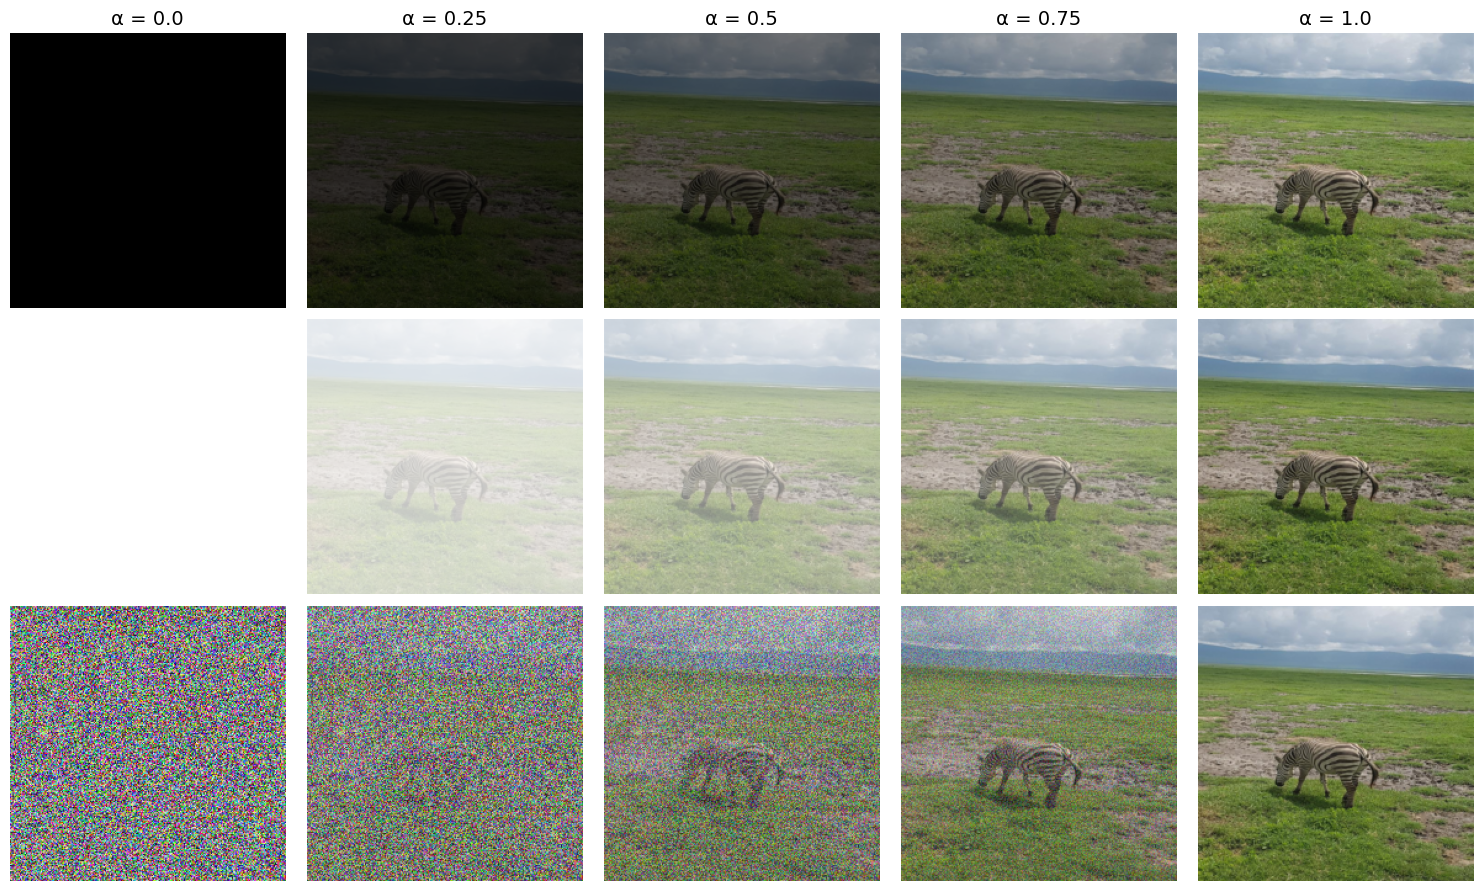

In [12]:
# Unnormalize for plotting
def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(3,1,1)
    return t * std + mean

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axes = plt.subplots(len(baselines), len(alphas), figsize=(3*len(alphas), 3*len(baselines)))
for row_idx, (bname, baseline) in enumerate(baselines.items()):
    for col_idx, alpha in enumerate(alphas):
        
        # interpolation in normalized space
        interp = baseline + alpha * (input_image - baseline)

        # convert to RGB for display
        img = unnormalize(interp.squeeze(0)).permute(1, 2, 0).cpu().clamp(0, 1)

        ax = axes[row_idx, col_idx]
        ax.imshow(img.detach().numpy())
        ax.axis("off")

        # column labels (top row only)
        if row_idx == 0:
            ax.set_title(f"α = {alpha}", fontsize=14)

plt.tight_layout()
plt.show()